https://ithelp.ithome.com.tw/articles/10233234  
Day 27 : 股市 K 線 LINE 聊天機器人實作 (功能實作)  
https://ithelp.ithome.com.tw/articles/10241574  

建立bbands教材，詳細說明策略的想法，並實際計算績效
1. 畫出bbands，並且沒有出現空缺
2. 完成不同策略的判斷、並畫出買賣點
3. 分析此策略的績效並改進

In [284]:
import os
path = "C:/Users/Landis/Desktop/pystocks"
lists = [i for i in os.listdir(path) if '.csv' in i]
print(lists)

['0050.csv', '0056.csv', '2317.csv', '2330.csv', '2610.csv']


<bound method NDFrame.head of              Open   High    Low  Close  Volume
Date                                          
2022-07-26  499.5  499.5  491.0  495.0   19524
2022-07-27  494.0  502.0  491.0  502.0   18411
2022-07-28  509.0  509.0  499.0  501.0   35021
2022-07-29  508.0  510.0  504.0  509.0   30633
2022-08-01  506.0  508.0  500.0  504.0   24991
2022-08-02  494.0  496.0  488.5  492.0   39702>


C:\Users\Landis\anaconda3\lib\site-packages\mplfinance\_arg_validators.py:35: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


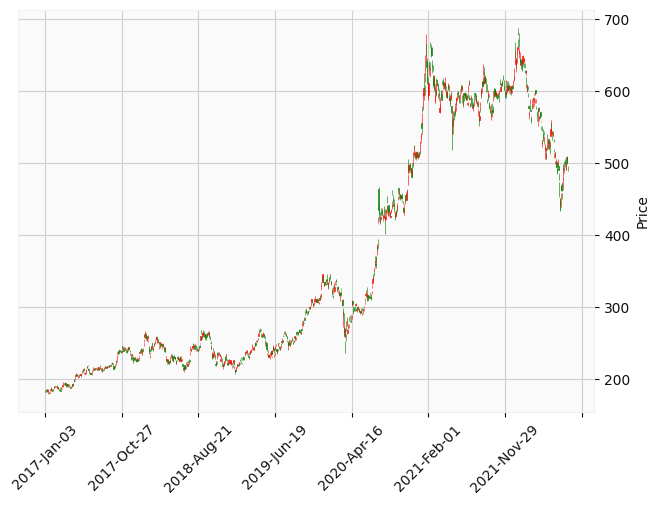

In [285]:
import pandas as pd
import mplfinance as mpf
# 讀取股票檔案，最新100筆資料
SData = pd.read_csv('2330.csv',index_col='Date')
# 更改時間格式
SData.index = pd.DatetimeIndex(SData.index)
print(SData.iloc[-6:,:].head)
mc = mpf.make_marketcolors(up='r', down='g', inherit=True)
s  = mpf.make_mpf_style(base_mpf_style='yahoo', marketcolors=mc)
mpf.plot(SData, type='candle', style =s)

In [286]:
print(len(SData))

1364


## 建立布林通道函式
1. 布林通道的定義為，K為標準差數量，N為過去幾筆資料:

    中軌 = N時間段的簡單移動平均線

    上軌 = 中軌 + K * N時間段的標準差

    下軌 =  中軌 - K * N時間段的標準差


2. 圖中藍線是上軌、橘線是中軌、綠色是下軌，常用的計算方式為N = 20、K = 2，也就是說中軌的每個點都是前20筆價格的平均

 

3. 標準差的計算方式為N時間段的每筆數值減去平均值的平方和再除以N後開根號，計算出來的標準差代回到布林通道的公式中就可以得到上下軌



In [287]:
def BBands(data, period=20, std_num=2):
    
    res = data.copy(deep=True)                                   # 取得data資料
    res['b_mid'] = data['Close'].rolling(period).mean()  # 計算中線(20日均線)
    std = data['Close'].rolling(period).std(ddof=0)              # 計算用於上下軌的標準差
    res['b_up'] = res['b_mid'] + std * std_num   # 計算上軌
    res['b_low'] = res['b_mid'] - std * std_num   # 計算下軌

    return res

In [288]:
SData = pd.read_csv('2330.csv',index_col='Date')
SData.index = pd.DatetimeIndex(SData.index)   # 更改時間格式
#print(SData)

bbands_data = BBands(SData)   # 將股價資訊經過BBands函式計算
#print(bbands_data)

# 新增布林通道後資訊
print(bbands_data.columns)
print(bbands_data)

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'b_mid', 'b_up', 'b_low'], dtype='object')
             Open   High    Low  Close  Volume    b_mid        b_up  \
Date                                                                  
2017-01-03  181.5  183.5  181.0  183.0   23551      NaN         NaN   
2017-01-04  183.0  184.0  181.5  183.0   24482      NaN         NaN   
2017-01-05  182.0  183.5  181.5  183.5   21374      NaN         NaN   
2017-01-06  184.0  184.5  183.5  184.0   23121      NaN         NaN   
2017-01-09  184.0  185.0  183.0  184.0   18584      NaN         NaN   
...           ...    ...    ...    ...     ...      ...         ...   
2022-07-27  494.0  502.0  491.0  502.0   18411  475.350  519.776456   
2022-07-28  509.0  509.0  499.0  501.0   35021  476.600  522.414408   
2022-07-29  508.0  510.0  504.0  509.0   30633  479.375  525.973149   
2022-08-01  506.0  508.0  500.0  504.0   24991  482.575  526.638902   
2022-08-02  494.0  496.0  488.5  492.0   39702  484.875 

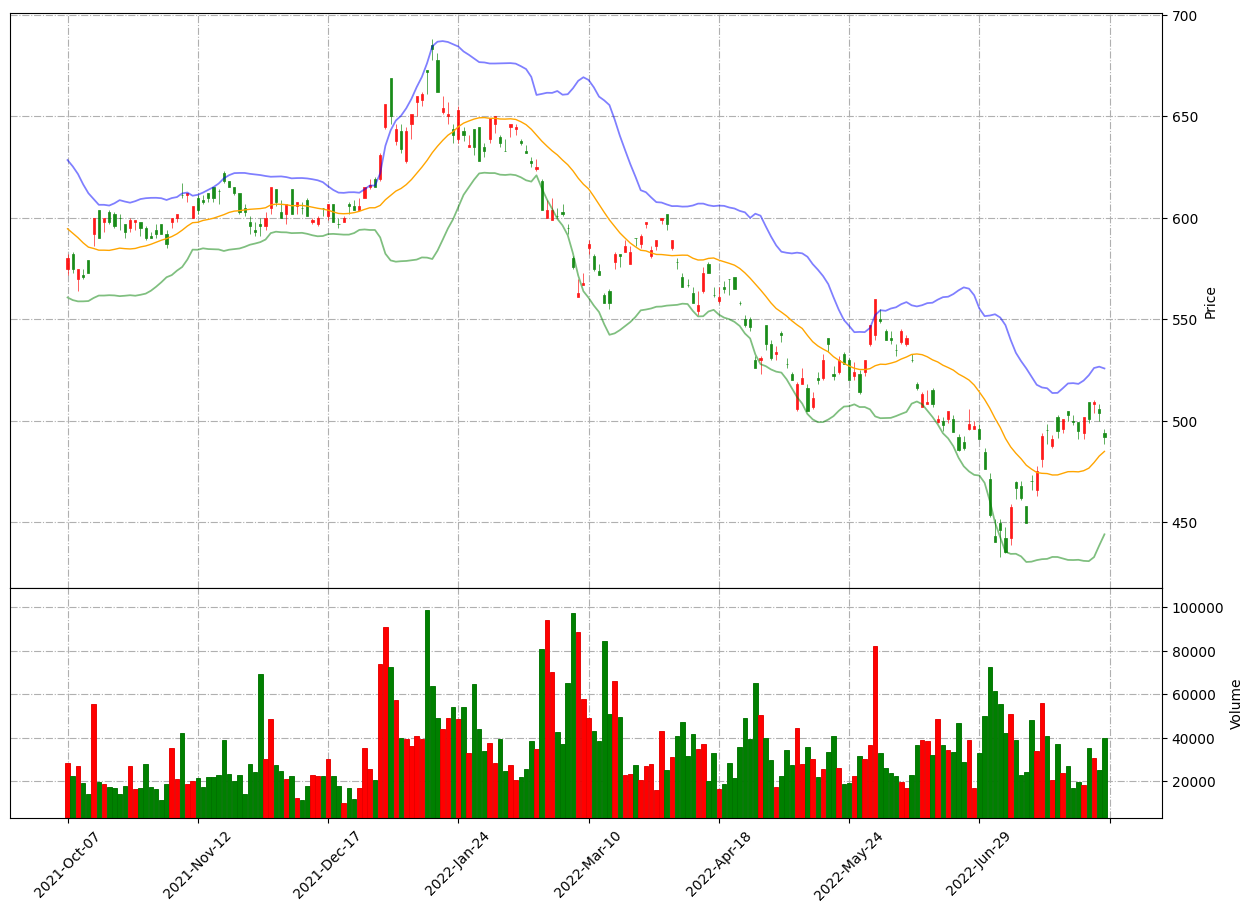

In [289]:
day_num = 200                            # 設定顯示股價資訊的天數
bbands_data = BBands(SData)              # 將股價資訊經過BBands函式計算
#print(bbands_data)

# 繪製布林通道線圖
addplots = [
            mpf.make_addplot(bbands_data['b_mid'][-day_num:], panel=0, color='orange', alpha=1
                             , width=1, secondary_y=False),
            mpf.make_addplot(bbands_data['b_up'][-day_num:], color = 'blue', alpha=0.5),
            mpf.make_addplot(bbands_data['b_low'][-day_num:], color = 'green', alpha=0.5)
           ]

# 設置k線圖顏色
my_color = mpf.make_marketcolors(up='red',      # 上漲顏色
                                 down='green',  # 下跌顏色
                                 edge='i',      # 隱藏 K 線邊緣
                                 volume='in',   # 成交量用同樣的顏色
                                 inherit=True)  # 繼承其他參數
# 設置圖型呈現
my_style = mpf.make_mpf_style(gridaxis='both',          # 設置網格
                              gridstyle='-.',           # 設定網格花樣
                              y_on_right=True,          # y 座標放右邊
                              marketcolors=my_color)    # 設定k線圖顏色

kwargs = dict(type = 'candle', 
              figscale = 2, # 設定圖型大小
              style = my_style)

_panel = 2
mpf.plot(SData.iloc[-day_num:,:],
         #mav = [10, 20, 60],
         **kwargs,
         num_panels=_panel,          # 設定總層數
         main_panel=0,               # 設定 K 線圖層數
         volume=True,              # 設定是否繪製成交量 
         volume_panel=_panel - 1,    # 設定成交量層數             
         show_nontrading=False,      # 忽略非交易日
         tight_layout=False,          # 設定布局方式
         addplot = addplots)

In [290]:
bbands_data.index

DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-09', '2017-01-10', '2017-01-11', '2017-01-12',
               '2017-01-13', '2017-01-16',
               ...
               '2022-07-20', '2022-07-21', '2022-07-22', '2022-07-25',
               '2022-07-26', '2022-07-27', '2022-07-28', '2022-07-29',
               '2022-08-01', '2022-08-02'],
              dtype='datetime64[ns]', name='Date', length=1364, freq=None)

In [291]:
bbands_data.loc['2021-01-04', 'Low']

528.0

In [292]:
SData.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

## 建立回測規則函式

In [293]:
import numpy as np

buy = [np.nan]
s = SData.copy(deep=True).iloc[-3:,:]
buy.append(np.nan)
buy.append(bbands_data.loc['2021-01-04', 'Low'])
print(buy)

s['sell_point'] = buy
print(s)


[nan, nan, 528.0]
             Open   High    Low  Close  Volume  sell_point
Date                                                      
2022-07-29  508.0  510.0  504.0  509.0   30633         NaN
2022-08-01  506.0  508.0  500.0  504.0   24991         NaN
2022-08-02  494.0  496.0  488.5  492.0   39702       528.0


In [427]:
import numpy as np
def bbands_rule(_ticker, bb_period=20, bb_stdnum=2):
    
    temp = 494.0 * 0.01  # 設定買賣點的距離
    
    # 複製一份資料，避免修改原始資料
    res = _ticker.copy(deep=True)

    # 檢查使否存在要用的指標
    try:
        if not {'b_mid', 'b_up', 'b_low'}.issubset(res.columns):
            res = BBands(res, bb_period, bb_stdnum)
    except Exception as e:
        print(e)
        return False

    # 新增一個空行，預設值為零
    b_slope = [np.nan]
    buy_1 = [np.nan]
    buy_2 = [np.nan]
    sell_1 = [np.nan]
    test = [np.nan]

    # 取得 index 值(日期)，方便計算使用
    t = res.index
    
    b_narrow = True
    
    # 判斷布林通道的斜率
#         if (s)>1:
#             test.append(bbands_data.loc[t[i], 'b_up'] + temp)
#             print("斜率:", (bbands_data.loc[t[i], 'b_up']/bbands_data.loc[t[i-1], 'b_up']-1) * 100)
#         else:
#             test.append(np.nan)

#             if (res.loc[t[i], 'Open'] < res.loc[t[i], 'Close']) and res.loc[t[i], 'Close'] > res.loc[t[i], 'b_up']:
#                 buy.append(res.loc[t[i], 'Low'] - temp)
#             else:    

    for i in range(1, len(res)):
        slope = (bbands_data.loc[t[i], 'b_up']/bbands_data.loc[t[i-1], 'b_up']-1) * 100    # 計算布林通道上軌斜率
        b_slope.append(slope)
        # 計算是否符合買進條件
        if ((bbands_data.loc[t[i], 'b_up']/bbands_data.loc[t[i], 'b_low']-1) * 100) > 15:  # 通道寬度大於15%
            test.append(400)
            if res.loc[t[i], 'Low'] < res.loc[t[i], 'b_low']:                              # K棒碰觸到下軌
                buy_1.append(res.loc[t[i], 'Low'] - temp)
                buy_2.append(np.nan)
                
                #print(t[i], "1.符合通道寬度大於15%且K棒碰觸到下軌")
            else:
                buy_1.append(np.nan)
                buy_2.append(np.nan)
#         elif ((bbands_data.loc[t[i], 'b_up']/bbands_data.loc[t[i], 'b_low']-1) * 100) < 15  and slope>0.8:
#             test.append(660)
#             if (res.loc[t[i], 'Close'] > res.loc[t[i], 'Open']) and res.loc[t[i], 'Close'] > res.loc[t[i], 'b_up']:
#                 buy_2.append(res.loc[t[i], 'Low'] - temp)
#                 buy_1.append(np.nan)
                
#                 #print(t[i], "符合上軌斜率大於1%且收紅K棒突破上軌")
#                 #print("成交量:", res.loc[t[i], 'Volume'])
#             else:
#                 buy_1.append(np.nan)
#                 buy_2.append(np.nan)    
        elif ((bbands_data.loc[t[i], 'b_up']/bbands_data.loc[t[i], 'b_low']-1) * 100) <= 5 :
            test.append(500)
            if (res.loc[t[i], 'Close'] > res.loc[t[i], 'Open']) and res.loc[t[i], 'Close'] > res.loc[t[i], 'b_up']:
                buy_2.append(res.loc[t[i], 'Low'] - temp)
                buy_1.append(np.nan)
                
                #print(t[i], "2.符合帶寬通道小於5%且收紅K棒突破上軌")
                #print("成交量:", res.loc[t[i], 'Volume'])
            else:
                buy_1.append(np.nan)
                buy_2.append(np.nan)    
        else:
            test.append(np.nan)
            buy_1.append(np.nan)
            buy_2.append(np.nan)

        # 計算是否符合做空首要條件
        if ((bbands_data.loc[t[i], 'b_up']/bbands_data.loc[t[i], 'b_low']-1) * 100) > 15: # 通道寬度大於15%
            if res.loc[t[i], 'Close'] > res.loc[t[i], 'b_up']:                            # 收盤價突破上軌
                sell_1.append(res.loc[t[i], 'High'] + temp)
            else:
                sell_1.append(np.nan)    
        else:
            sell_1.append(np.nan)
    res['buy_point'] = buy_1
    res['buy2_point'] = buy_2
    res['sell_point'] = sell_1
    res['bband_slope'] = b_slope
    res['test'] = test
    return res

In [428]:
bbands_data = bbands_rule(SData)

## 關於新增線圖的設定(官方文檔)
https://github.com/matplotlib/mplfinance/blob/master/examples/addplot.ipynb

In [381]:
bband_line = bbands_data[['b_mid','b_up','b_low']][-day_num:]
#bband_line

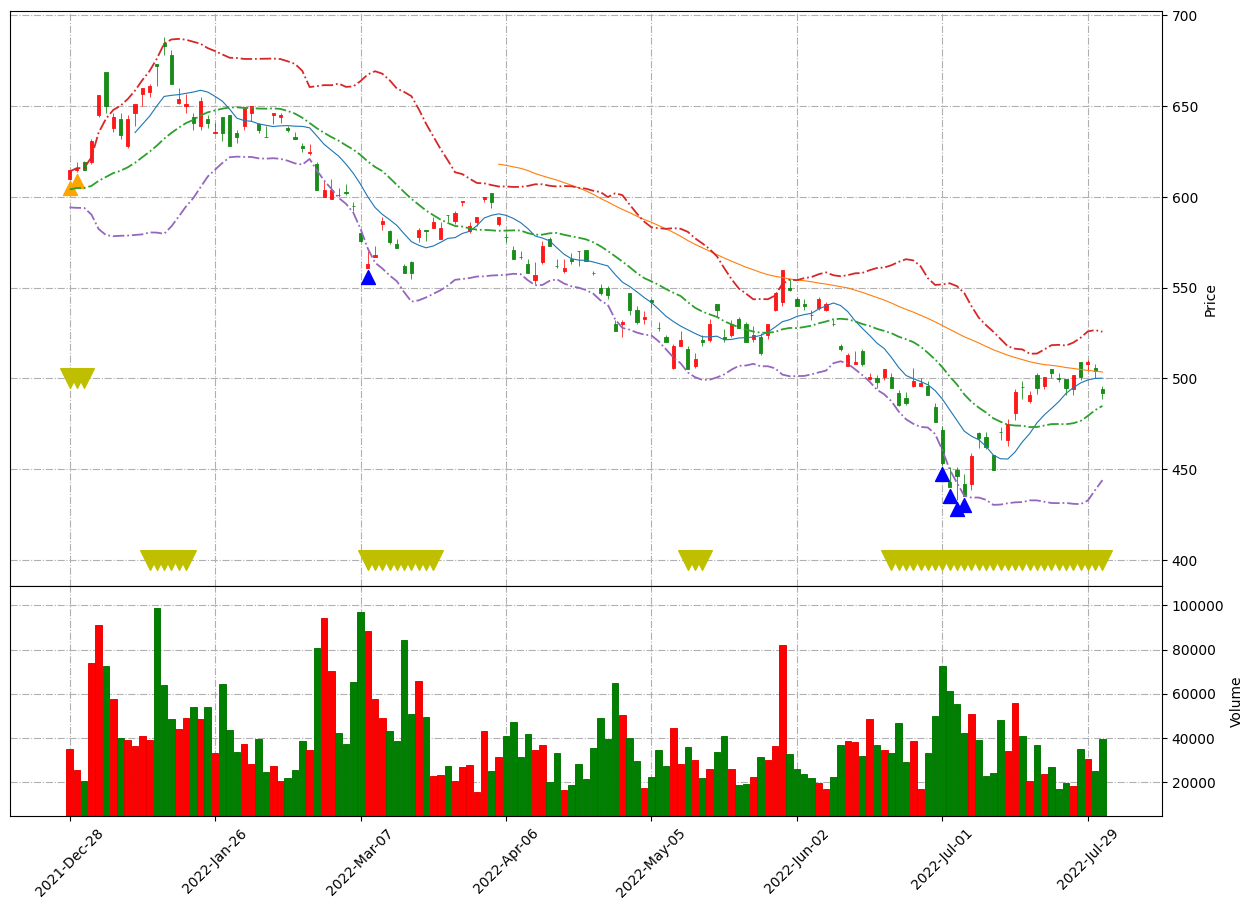

In [429]:
# range
day_num = '2021-12-28'                        # 設定顯示股價資訊起始日期
day_end = '2022-08-03'                        # 設定顯示股價資訊結束日期

bbands_data = bbands_rule(SData)              # 將股價資訊經過BBands函式計算
#print(bbands_data)

# 繪製布林通道線圖

bband_line = bbands_data[['b_mid','b_up','b_low']][day_num:day_end]

addplots = [
            mpf.make_addplot(bband_line, panel=0,linestyle='dashdot'),
            #mpf.make_addplot(bbands_data['b_up'][day_num:day_end], color = 'blue', alpha=0.5),
            #mpf.make_addplot(bbands_data['b_low'][day_num:day_end], color = 'green', alpha=0.5),
            mpf.make_addplot(bbands_data['buy_point'][day_num:day_end], color = 'blue', alpha=1, type='scatter', marker='^', markersize=100),
            mpf.make_addplot(bbands_data['buy2_point'][day_num:day_end], color = 'orange', alpha=1, type='scatter', marker='^', markersize=100),
            #mpf.make_addplot(bbands_data['sell_point'][day_num:day_end], color = 'green', alpha=0.5, type='scatter', marker='v', markersize=100),
            mpf.make_addplot(bbands_data['test'][day_num:day_end], color = 'y', type='scatter',markersize=200, marker='v')
           ]

# 設置k線圖顏色
my_color = mpf.make_marketcolors(up='red',      # 上漲顏色
                                 down='green',  # 下跌顏色
                                 edge='i',      # 隱藏 K 線邊緣
                                 volume='in',   # 成交量用同樣的顏色
                                 inherit=True)  # 繼承其他參數
# 設置圖型呈現
my_style = mpf.make_mpf_style(gridaxis='both',          # 設置網格
                              gridstyle='-.',           # 設定網格花樣
                              y_on_right=True,          # y 座標放右邊
                              marketcolors=my_color)    # 設定k線圖顏色

kwargs = dict(type = 'candle', 
              figscale = 2, # 設定圖型大小
              style = my_style)

_panel = 2
mpf.plot(SData.loc[day_num:day_end,:],
         mav = [10, 60],
         **kwargs,
         num_panels=_panel,          # 設定總層數
         main_panel=0,               # 設定 K 線圖層數
         volume=True,              # 設定是否繪製成交量 
         volume_panel=_panel - 1,    # 設定成交量層數             
         show_nontrading=False,      # 忽略非交易日
         tight_layout=False,          # 設定布局方式
         addplot = addplots)

In [343]:
?mpf.make_addplot
?type

In [390]:
SData.iloc[-day_num:,:]

,Open,High,Low,Close,Volume
Date,,,,,
2021-10-07,575.0,582.0,572.0,580.0,28480
2021-10-08,582.0,583.0,573.0,575.0,22602
2021-10-12,570.0,575.0,564.0,575.0,27126
2021-10-13,572.0,575.0,570.0,571.0,19267
2021-10-14,579.0,579.0,573.0,573.0,14271
...,...,...,...,...,...
2022-07-27,494.0,502.0,491.0,502.0,18411
2022-07-28,509.0,509.0,499.0,501.0,35021
2022-07-29,508.0,510.0,504.0,509.0,30633


In [402]:
bbands_data.loc['2021-12-28':]['buy2_point']

Date
2021-12-28    605.06
2021-12-29    609.06
2021-12-30       NaN
2022-01-03       NaN
2022-01-04       NaN
               ...  
2022-07-27       NaN
2022-07-28       NaN
2022-07-29       NaN
2022-08-01       NaN
2022-08-02       NaN
Name: buy2_point, Length: 143, dtype: float64

In [437]:
bbands_data

,Open,High,Low,Close,Volume,b_mid,b_up,b_low,buy_point,buy2_point,sell_point,bband_slope,test
Date,,,,,,,,,,,,,
2017-01-03,181.5,183.5,181.0,183.0,23551,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,183.0,184.0,181.5,183.0,24482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-05,182.0,183.5,181.5,183.5,21374,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-06,184.0,184.5,183.5,184.0,23121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-09,184.0,185.0,183.0,184.0,18584,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-27,494.0,502.0,491.0,502.0,18411,475.350,519.776456,430.923544,NaN,NaN,NaN,0.313411,400.0
2022-07-28,509.0,509.0,499.0,501.0,35021,476.600,522.414408,430.785592,NaN,NaN,NaN,0.507517,400.0
2022-07-29,508.0,510.0,504.0,509.0,30633,479.375,525.973149,432.776851,NaN,NaN,NaN,0.681210,400.0


In [440]:
bbands_data.loc['2017-05-10']

Open             204.000000
High             206.000000
Low              204.000000
Close            205.500000
Volume         31076.000000
b_mid            193.625000
b_up             204.692407
b_low            182.557593
buy_point               NaN
buy2_point              NaN
sell_point              NaN
bband_slope        1.046422
test                    NaN
Name: 2017-05-10 00:00:00, dtype: float64

In [426]:
for i,j in enumerate(bbands_data['bband_slope']):
    if j >= 1:
        print(bbands_data.index[i].date(), '斜率為:', round(j,2))

2017-05-08 斜率為: 1.01
2017-05-10 斜率為: 1.05
2017-05-11 斜率為: 1.12
2017-10-11 斜率為: 1.47
2017-10-12 斜率為: 1.72
2017-10-13 斜率為: 1.31
2017-10-16 斜率為: 1.12
2018-01-04 斜率為: 1.08
2018-01-19 斜率為: 1.37
2018-01-22 斜率為: 1.81
2018-01-23 斜率為: 1.92
2018-07-20 斜率為: 1.38
2018-07-23 斜率為: 1.95
2018-07-24 斜率為: 1.49
2018-07-25 斜率為: 1.12
2018-07-27 斜率為: 1.17
2018-08-29 斜率為: 1.34
2018-08-30 斜率為: 1.69
2018-10-11 斜率為: 1.55
2019-07-22 斜率為: 1.15
2019-10-01 斜率為: 1.33
2019-10-08 斜率為: 1.16
2019-10-14 斜率為: 1.09
2019-10-15 斜率為: 1.21
2019-10-16 斜率為: 1.22
2019-12-12 斜率為: 1.64
2019-12-13 斜率為: 1.99
2019-12-16 斜率為: 1.2
2019-12-17 斜率為: 1.7
2019-12-18 斜率為: 1.36
2020-04-17 斜率為: 1.87
2020-06-05 斜率為: 1.11
2020-06-08 斜率為: 1.45
2020-06-09 斜率為: 1.31
2020-06-10 斜率為: 1.35
2020-07-06 斜率為: 1.37
2020-07-07 斜率為: 1.18
2020-07-08 斜率為: 1.16
2020-07-09 斜率為: 1.26
2020-07-10 斜率為: 1.28
2020-07-13 斜率為: 1.54
2020-07-14 斜率為: 1.94
2020-07-15 斜率為: 1.46
2020-07-17 斜率為: 1.32
2020-07-20 斜率為: 1.03
2020-07-21 斜率為: 1.81
2020-07-22 斜率為: 1.45
2020-07-23 斜率為:

In [436]:
print("買點1.符合通道寬度大於15%且K棒碰觸到下軌")
print("買點2.符合帶寬通道小於5%且收紅K棒突破上軌")
for i,j in enumerate(bbands_data['buy2_point']):
    if 'nan' not in str(j):
        print(bbands_data.index[i].date(), '出現買點2')
for i,j in enumerate(bbands_data['buy_point']):
    if 'nan' not in str(j):
        print(bbands_data.index[i].date(), '出現買點1')

買點1.符合通道寬度大於15%且K棒碰觸到下軌
買點2.符合帶寬通道小於5%且收紅K棒突破上軌
2017-02-13 出現買點2
2017-04-28 出現買點2
2017-06-05 出現買點2
2017-09-20 出現買點2
2018-01-02 出現買點2
2021-12-28 出現買點2
2021-12-29 出現買點2
2018-02-09 出現買點1
2018-04-26 出現買點1
2018-10-12 出現買點1
2018-10-15 出現買點1
2018-10-16 出現買點1
2019-05-21 出現買點1
2019-05-23 出現買點1
2020-03-13 出現買點1
2020-03-16 出現買點1
2020-03-17 出現買點1
2020-03-18 出現買點1
2020-03-19 出現買點1
2022-03-08 出現買點1
2022-07-01 出現買點1
2022-07-04 出現買點1
2022-07-05 出現買點1
2022-07-06 出現買點1


## 互動式繪圖
https://cxyzjd.com/article/Shepherdppz/117575286